In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import pandas as pd

# Funções de suporte

A seguir são descritas as funções criadas para facilitar o entendimento do algoritmo, aplicando o princípio da responsabilidade única.

## Matriz $\hat{\theta}$

Função criada para encapsular o código responsável pela estimação dos parâmetros da matriz $\theta$.

Essa função implementa a seguinte equação:

$$\hat{\theta} = \left[ \phi^T \phi \right]^{-1} \phi^T Y$$

Por coveniência, foi criada também uma função para retornar dois vetores, um de polos e outro de zeros, obtidos à partir de $\hat{\theta}$.

In [2]:
def calculate_theta(u: np.ndarray, y: np.ndarray, poles: int, zeros: int, delay: int = 0) -> np.ndarray:
    assert len(u) == len(y)
    size = len(u)
    result = np.zeros([size, poles + zeros])

    for i in range(size):
        for j in range(poles):
            result[i][j] = -y[max(i - j - 1, 0)]

        for j in range(zeros):
            result[i][poles + j] = u[max(i - j - delay - 1, 0)]

    return np.linalg.inv(result.T @ result) @ result.T @ y[:size]

def convert_theta_to_ab(theta: np.ndarray, poles: int) -> tuple[np.ndarray, np.ndarray]:
    return -theta[:poles], theta[poles:]

## Estimação das saídas do sistema modelo

Essa função é responsável por estimar quais serão os valores da saída do sistema à partir dos vetores de polos e zeros

In [3]:
def estimate(u: np.ndarray, y: np.ndarray, a: np.ndarray, b: np.ndarray, delay: int = 0, n_steps: bool = False) -> np.ndarray:
    order = max(len(a), len(b))

    y_hat = y.copy()
    y_hat[order:] = 0

    for t in range(order, len(u)):
            for i, a_i in enumerate(a):
                if n_steps:
                    y_hat[t] += a_i * y_hat[max(t - i - 1, 0)]
                else:
                    y_hat[t] += a_i * y[max(t - i - 1, 0)]

            for i, b_i in enumerate(b):
                y_hat[t] += b_i * u[max(t - i - delay - 1, 0)]

    return y_hat

## Erros quadáticos médios

Função responsável por retornar a média dos quadrados dos erros (MSE):

$$MSE = \frac{1}{N} \sum^N_{i=1} \left[ \hat{y_i} - y_i \right]^2$$

In [4]:
def mse(y: np.ndarray, y_hat: np.ndarray) -> float:
    return np.square(np.subtract(y, y_hat)).mean()

## Testes de normalidade

Foram utilizados os testes de Anderson-Darling e Shapiro-Wilk para determinar se os resíduos podem ser considerados ruído branco, $\mathcal{N}(0, \sigma)$.

In [5]:
# Fonte: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

def shapiro(data):
    stat, p = sp.shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

def anderson_darling(data):
    result = sp.anderson(data)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))


## Preparação dos dados

Esta função recebe os dados e os separa em dois conjuntos de entrada e saída, o primeiro para estimação e o segundo para validação.

In [6]:
def prepare_data(data: pd.DataFrame) -> tuple[np.array, np.array, np.array, np.array]:
    u = data.u.to_numpy()
    y = data.y.to_numpy()

    est_size = int(0.7 * len(data))

    u_est = u[:est_size]
    y_est = y[:est_size]

    u_val = u[est_size:]
    y_val = y[est_size:]

    return u_est, y_est, u_val, y_val

## Processamento dos dados

Esta função recebe os conjuntos de dados para estimação e validação, e executa todo processo de identificação e simulação do modelo, exibindo os resultados na tela.

In [7]:
def process_data(u_est: np.array, y_est: np.array, u_val: np.array, y_val: np.array, pole_count: int, zero_count: int) -> None:
    x = np.linspace(y_val.min(), y_val.max(), 200)

    theta = calculate_theta(u_est, y_est, poles=pole_count, zeros=zero_count)
    a, b = convert_theta_to_ab(theta=theta, poles=pole_count)

    y_hat = estimate(u_val, y_val, a=a, b=b, n_steps=False)
    y_n_steps = estimate(u_val, y_val, a=a, b=b, n_steps=True)

    fig, (plt1, plt2, plt3) = plt.subplots(1, 3)

    fig.set_figwidth(20)
    fig.suptitle(f'{pole_count} polo{"s" if pole_count > 1 else ""}, {zero_count} zero{"s" if zero_count > 1 else ""}')

    plt1.plot(y_val, linestyle='-')
    plt1.plot(y_hat, linestyle='--')
    plt1.plot(y_n_steps, linestyle=':')
    plt1.set_xlabel('Amostra')
    plt1.set_ylabel('Saída')
    
    plt2.scatter(y_val, y_hat, s=0.5)
    plt2.plot(x, x, 'r')
    plt2.set_title('1 passo à frente')
    plt2.set_xlabel('Saída observada')
    plt2.set_ylabel('Saída estimada')

    plt3.scatter(y_val, y_n_steps, s=0.5)
    plt3.plot(x, x, 'r')
    plt3.set_title('N passos à frente')
    plt3.set_xlabel('Saída observada')
    plt3.set_ylabel('Saída estimada')

    print('Parâmetros estimados\n')

    print(f'a = {a}')
    print(f'b = {b}')

    print('\n1 passo à frente')

    summary = pd.DataFrame([[mse(y_val, y_hat), np.corrcoef(y_val, y_hat)[0, 1] ** 2, np.mean(y_val - y_hat), np.std(y_val - y_hat)]],
                            index=['y_hat'],
                            columns=['MSE', 'R^2', 'Média (Erro)', 'Desvio padrão (Erro)'])
    print(summary)

    print()

    shapiro(y_hat - y_val)
    anderson_darling(y_hat - y_val)

    print('\nN passos à frente')

    summary = pd.DataFrame([[mse(y_val, y_n_steps), np.corrcoef(y_val, y_n_steps)[0, 1] ** 2, np.mean(y_val - y_n_steps), np.std(y_val - y_n_steps)]],
                            index=['y_n_steps'],
                            columns=['MSE', 'R^2', 'Média (Erro)', 'Desvio padrão (Erro)'])
    print(summary)

    print()

    shapiro(y_n_steps - y_val)
    anderson_darling(y_n_steps - y_val)

# Modelagem do primeiro sistema

Para essa primeira modelagem, foi utilizado os dados de uma montagem de laboratório agindo como um secador de cabelo.

Os dados consistem em uma entrada, representando a tensão aplicada nos resistores de aquecimento, e uma saída, representando a temperatura do ar aquecido, e estão disponíveis no [link](http://ftp.esat.kuleuven.be/pub/SISTA/data/mechanical/dryer.dat.gz).

In [8]:
url = 'http://ftp.esat.kuleuven.be/pub/SISTA/data/mechanical/dryer.dat.gz'
data = pd.read_csv(url, sep='\t', usecols=[0, 1], names=['u', 'y'])
print(data)

u_est, y_est, u_val, y_val = prepare_data(data)

        u         y
0    6.41  4.766099
1    3.41  4.763659
2    6.41  4.839359
3    6.41  5.002979
4    6.41  5.017629
..    ...       ...
995  6.41  4.145839
996  6.41  3.965129
997  6.41  4.033499
998  6.41  4.372939
999  6.41  4.683079

[1000 rows x 2 columns]


## Modelagem com 1 zero e 1 polo

Parâmetros estimados

a = [0.95633079]
b = [0.04270688]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.039575  0.930149      0.000459              0.198935

Statistics=0.993, p=0.145
Sample looks Gaussian (fail to reject H0)
Statistic: 0.665
15.000: 0.569, data does not look normal (reject H0)
10.000: 0.648, data does not look normal (reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks normal (fail to reject H0)
1.000: 1.078, data looks normal (fail to reject H0)

N passos à frente
                MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  0.281191  0.549318      0.044236              0.528426

Statistics=0.975, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 2.678
15.000: 0.569, data does not look normal (reject H0)
10.000: 0.648, data does not look normal (reject H0)
5.000: 0.777, data does not look normal (reject H0)
2.500: 0.906, data does not look normal (reject H0)
1.000: 

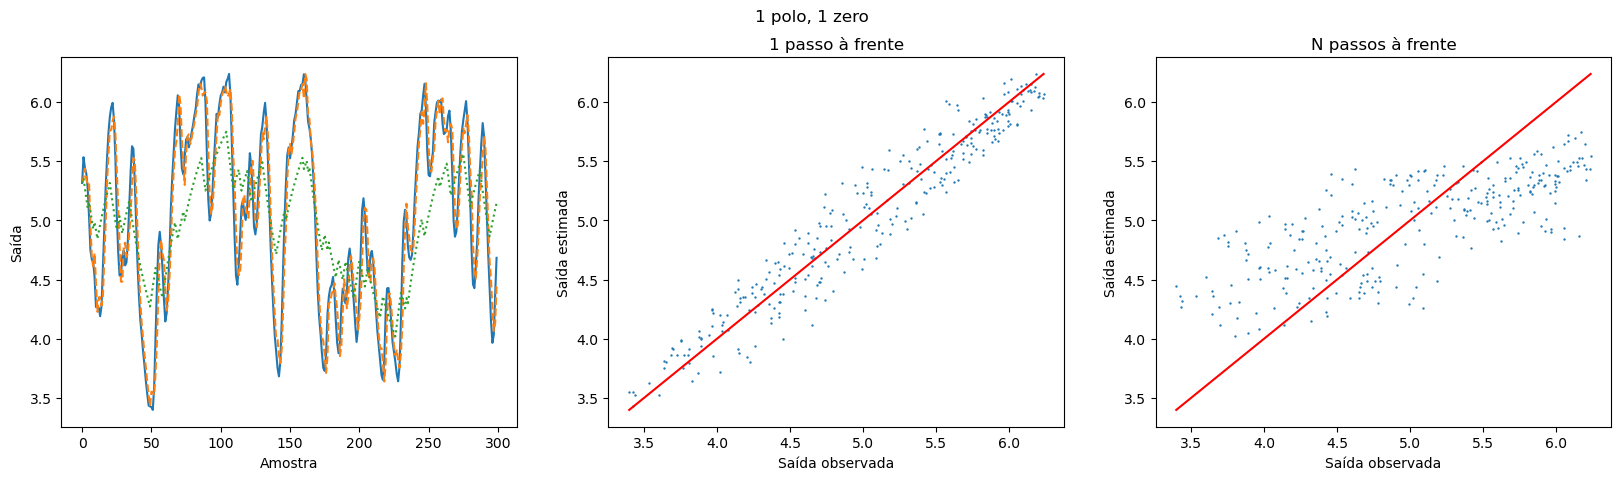

In [9]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=1, pole_count=1)

## Modelagem com 1 zero e 2 polos

Parâmetros estimados

a = [ 1.75112664 -0.78440099]
b = [0.03165682]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.013269  0.977945      0.006148              0.115028

Statistics=0.993, p=0.148
Sample looks Gaussian (fail to reject H0)
Statistic: 0.441
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks normal (fail to reject H0)
1.000: 1.078, data looks normal (fail to reject H0)

N passos à frente
               MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  0.10739  0.861089      0.169169              0.280664

Statistics=0.994, p=0.320
Sample looks Gaussian (fail to reject H0)
Statistic: 0.329
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks normal (fail to reject 

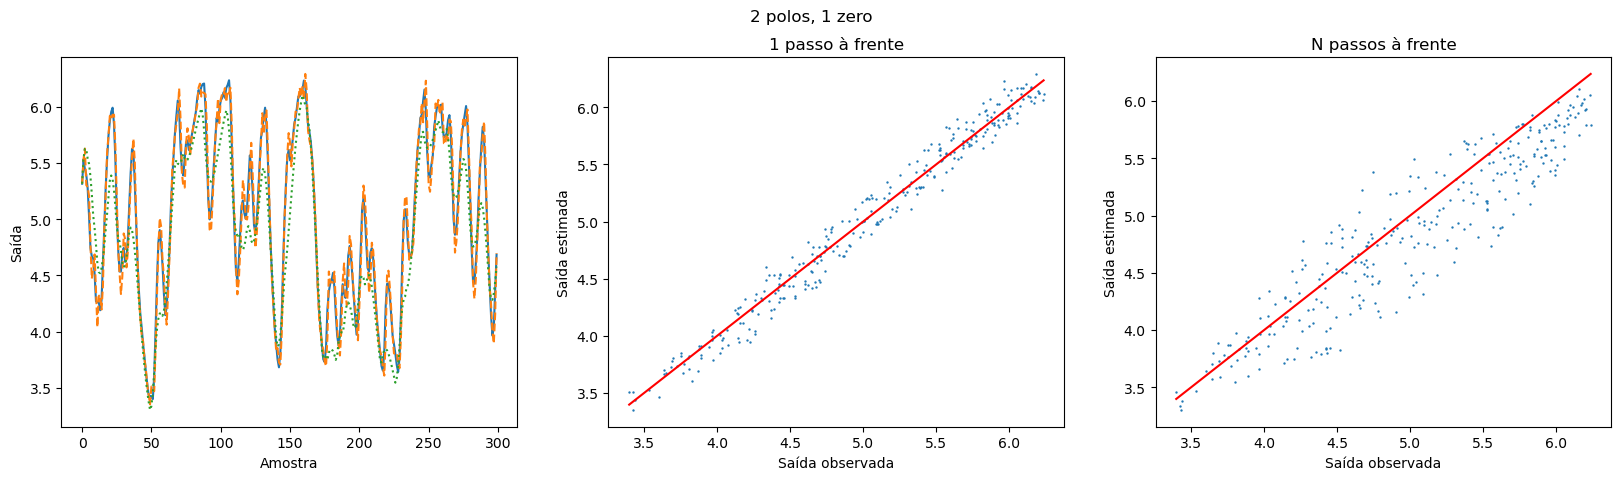

In [10]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=1, pole_count=2)

## Modelagem com 1 zero e 3 polos

Parâmetros estimados

a = [ 2.10681848 -1.55371976  0.42116933]
b = [0.0247954]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.009866  0.982873      0.003303              0.099273

Statistics=0.994, p=0.241
Sample looks Gaussian (fail to reject H0)
Statistic: 0.460
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks normal (fail to reject H0)
1.000: 1.078, data looks normal (fail to reject H0)

N passos à frente
                MSE      R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  0.111632  0.85614      0.132511              0.306713

Statistics=0.985, p=0.004
Sample does not look Gaussian (reject H0)
Statistic: 1.316
15.000: 0.569, data does not look normal (reject H0)
10.000: 0.648, data does not look normal (reject H0)
5.000: 0.777, data does not look normal (reject H0)
2.500: 0.906, data does not look norm

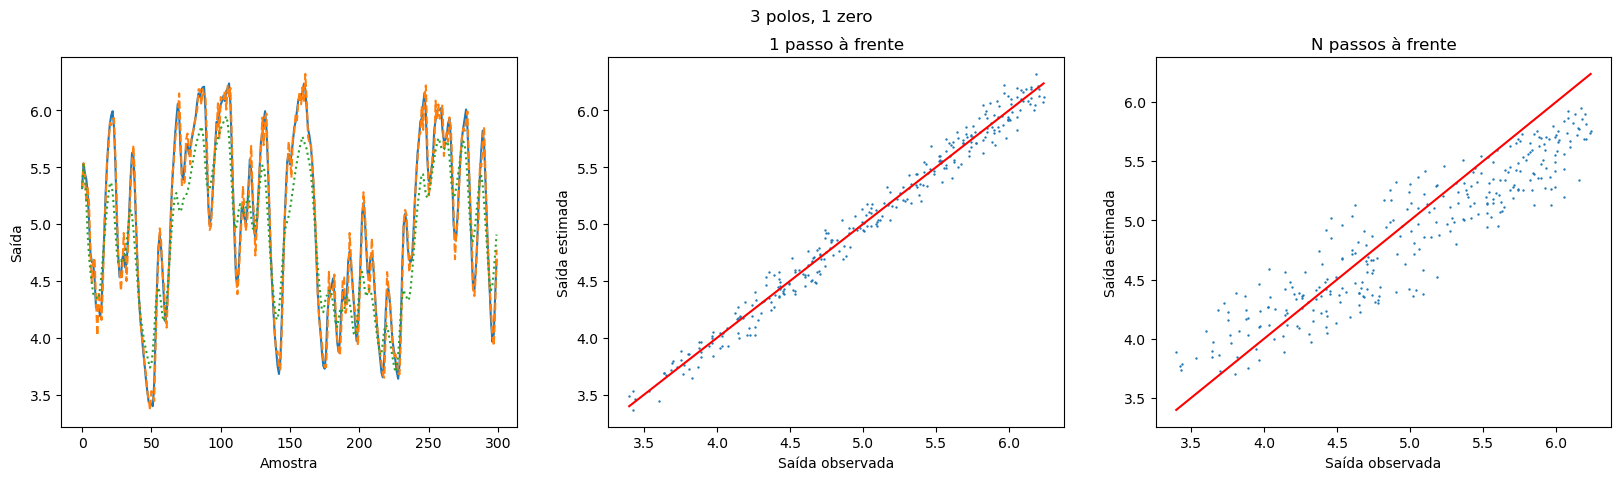

In [11]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=1, pole_count=3)

## Modelagem com 2 zeros e 1 polo

Parâmetros estimados

a = [0.93191496]
b = [-0.00255092  0.06926906]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.032679  0.942471      0.000714              0.180772

Statistics=0.996, p=0.664
Sample looks Gaussian (fail to reject H0)
Statistic: 0.219
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks normal (fail to reject H0)
1.000: 1.078, data looks normal (fail to reject H0)

N passos à frente
                MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  0.180191  0.711817      0.027889              0.423572

Statistics=0.980, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 1.891
15.000: 0.569, data does not look normal (reject H0)
10.000: 0.648, data does not look normal (reject H0)
5.000: 0.777, data does not look normal (reject H0)
2.500: 0.906, data does not look normal (rejec

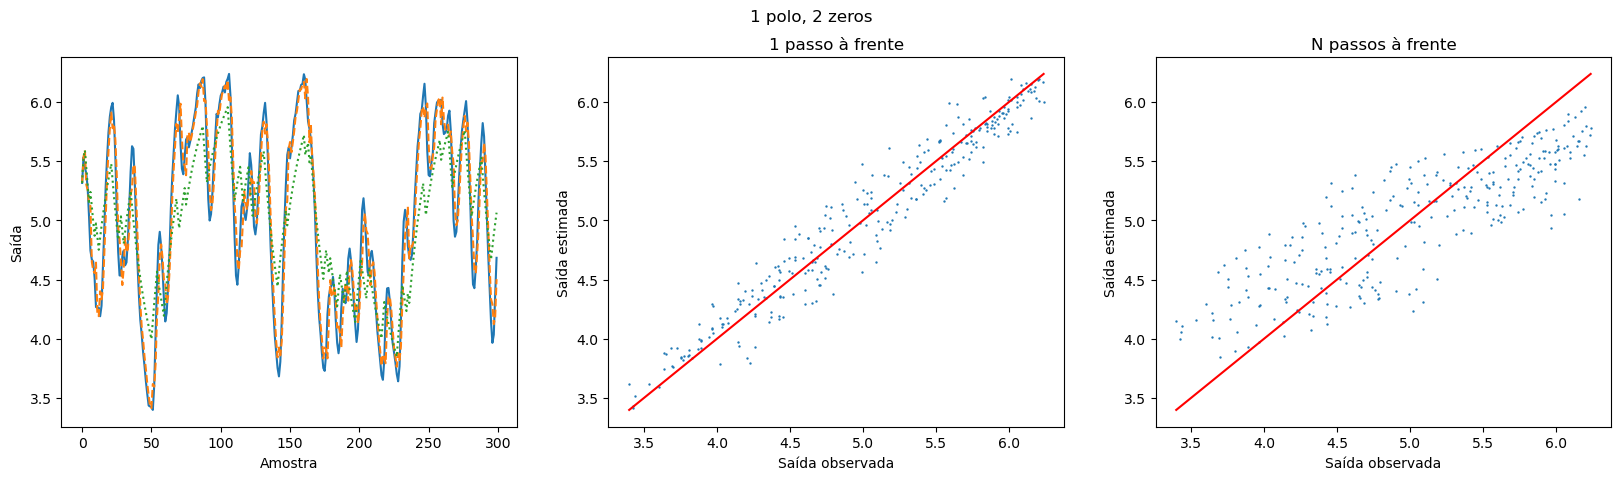

In [12]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=2, pole_count=1)

## Modelagem com 2 zeros e 2 polos

Parâmetros estimados

a = [ 1.68459634 -0.73377958]
b = [0.00412427 0.04323124]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.010009  0.983001      0.006268              0.099846

Statistics=0.996, p=0.670
Sample looks Gaussian (fail to reject H0)
Statistic: 0.240
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks normal (fail to reject H0)
1.000: 1.078, data looks normal (fail to reject H0)

N passos à frente
                MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  0.053919  0.931432      0.119179              0.199287

Statistics=0.991, p=0.054
Sample looks Gaussian (fail to reject H0)
Statistic: 0.872
15.000: 0.569, data does not look normal (reject H0)
10.000: 0.648, data does not look normal (reject H0)
5.000: 0.777, data does not look normal (reject H0)
2.500: 0.906, data looks normal (fa

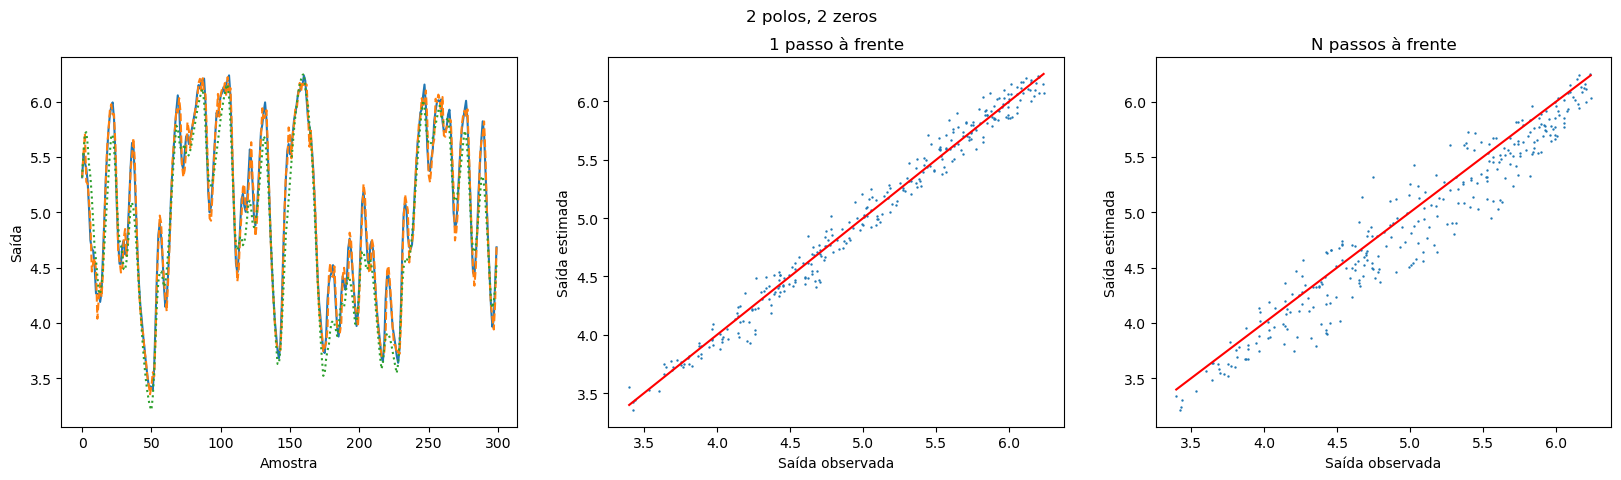

In [13]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=2, pole_count=2)

## Modelagem com 2 zeros e 3 polos

Parâmetros estimados

a = [ 1.98884705 -1.37584419  0.34675136]
b = [0.00319599 0.03581875]

1 passo à frente
            MSE      R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.007628  0.98666      0.004245              0.087233

Statistics=0.996, p=0.592
Sample looks Gaussian (fail to reject H0)
Statistic: 0.302
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks normal (fail to reject H0)
1.000: 1.078, data looks normal (fail to reject H0)

N passos à frente
                MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  0.043677  0.948852      0.107144              0.179436

Statistics=0.991, p=0.074
Sample looks Gaussian (fail to reject H0)
Statistic: 0.536
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks 

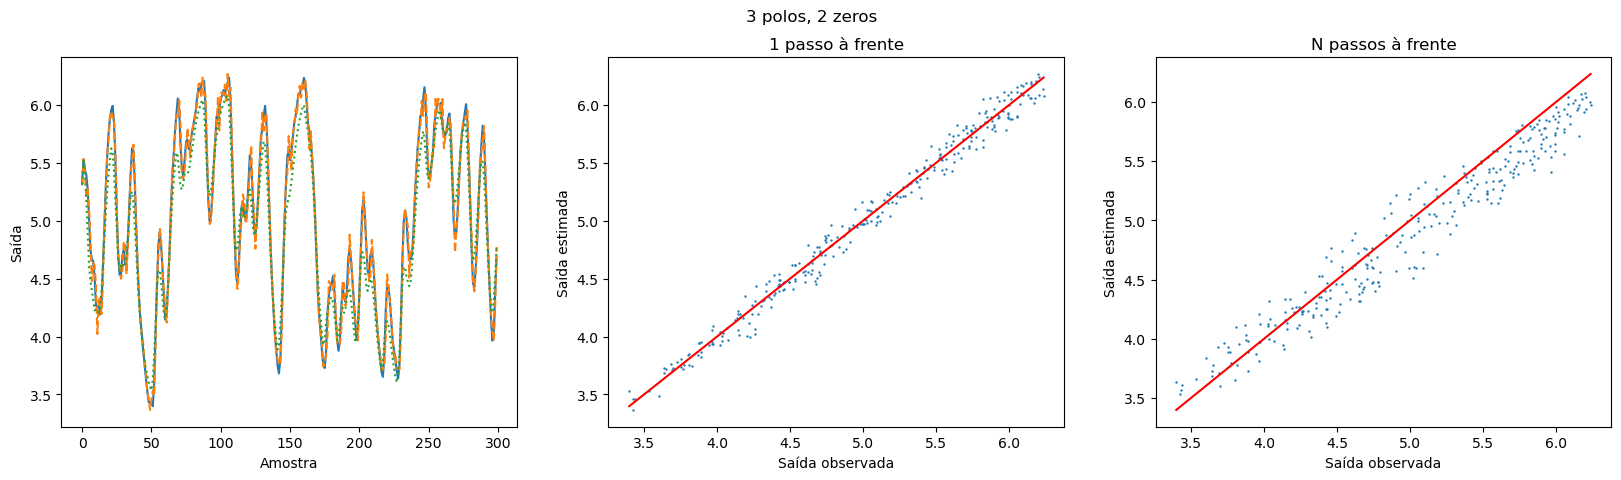

In [14]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=2, pole_count=3)

## Modelagem com 3 zeros e 1 polo

Parâmetros estimados

a = [0.88699234]
b = [-0.00288235  0.00206773  0.11137313]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.015722  0.972767      0.004563              0.125302

Statistics=0.995, p=0.469
Sample looks Gaussian (fail to reject H0)
Statistic: 0.253
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks normal (fail to reject H0)
1.000: 1.078, data looks normal (fail to reject H0)

N passos à frente
                MSE      R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  0.070425  0.89183      0.046138              0.261336

Statistics=0.988, p=0.013
Sample does not look Gaussian (reject H0)
Statistic: 0.931
15.000: 0.569, data does not look normal (reject H0)
10.000: 0.648, data does not look normal (reject H0)
5.000: 0.777, data does not look normal (reject H0)
2.500: 0.906, data does not look nor

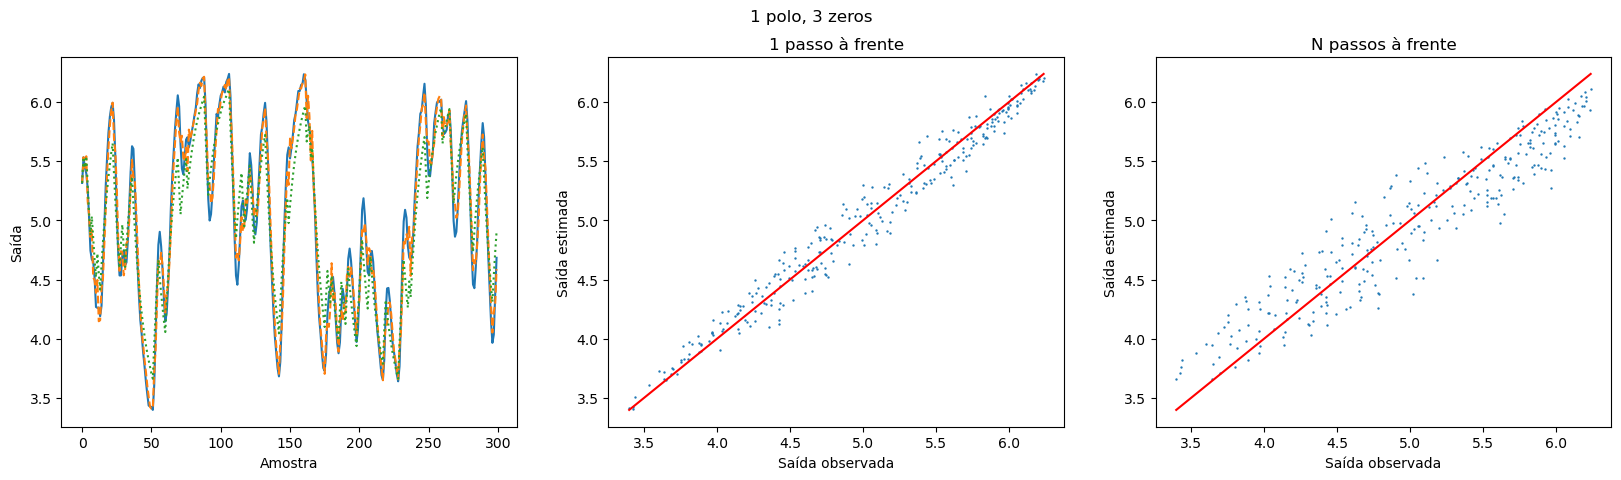

In [15]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=3, pole_count=1)

## Modelagem com 3 zeros e 2 polos

Parâmetros estimados

a = [ 1.49461585 -0.57779708]
b = [0.00248411 0.00391815 0.07432692]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.003124  0.994696      0.008133              0.055299

Statistics=0.993, p=0.172
Sample looks Gaussian (fail to reject H0)
Statistic: 0.374
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks normal (fail to reject H0)
1.000: 1.078, data looks normal (fail to reject H0)

N passos à frente
                MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  0.016869  0.987714      0.095473              0.088054

Statistics=0.994, p=0.248
Sample looks Gaussian (fail to reject H0)
Statistic: 0.364
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks

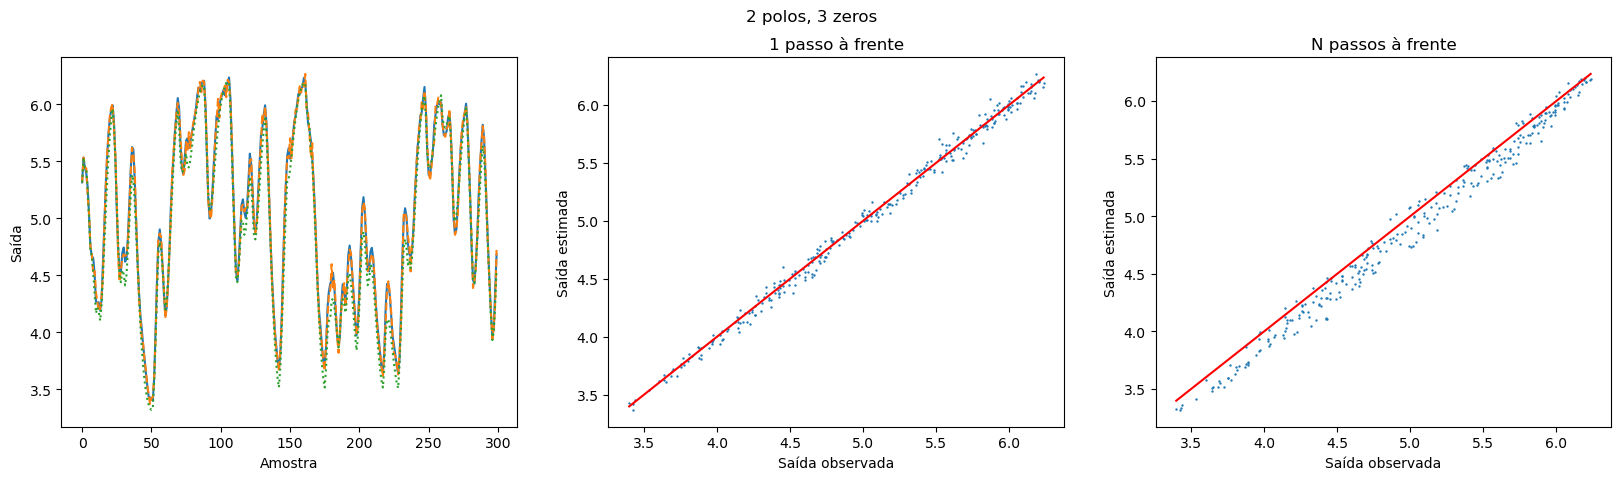

In [16]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=3, pole_count=2)

## Modelagem com 3 zeros e 3 polos

Parâmetros estimados

a = [ 1.64887671 -0.88706287  0.16142439]
b = [0.00216094 0.00307927 0.06938878]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.002723  0.995293      0.006713              0.051747

Statistics=0.995, p=0.499
Sample looks Gaussian (fail to reject H0)
Statistic: 0.362
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906, data looks normal (fail to reject H0)
1.000: 1.078, data looks normal (fail to reject H0)

N passos à frente
                MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  0.013489  0.989751      0.087507              0.076366

Statistics=0.996, p=0.653
Sample looks Gaussian (fail to reject H0)
Statistic: 0.308
15.000: 0.569, data looks normal (fail to reject H0)
10.000: 0.648, data looks normal (fail to reject H0)
5.000: 0.777, data looks normal (fail to reject H0)
2.500: 0.906

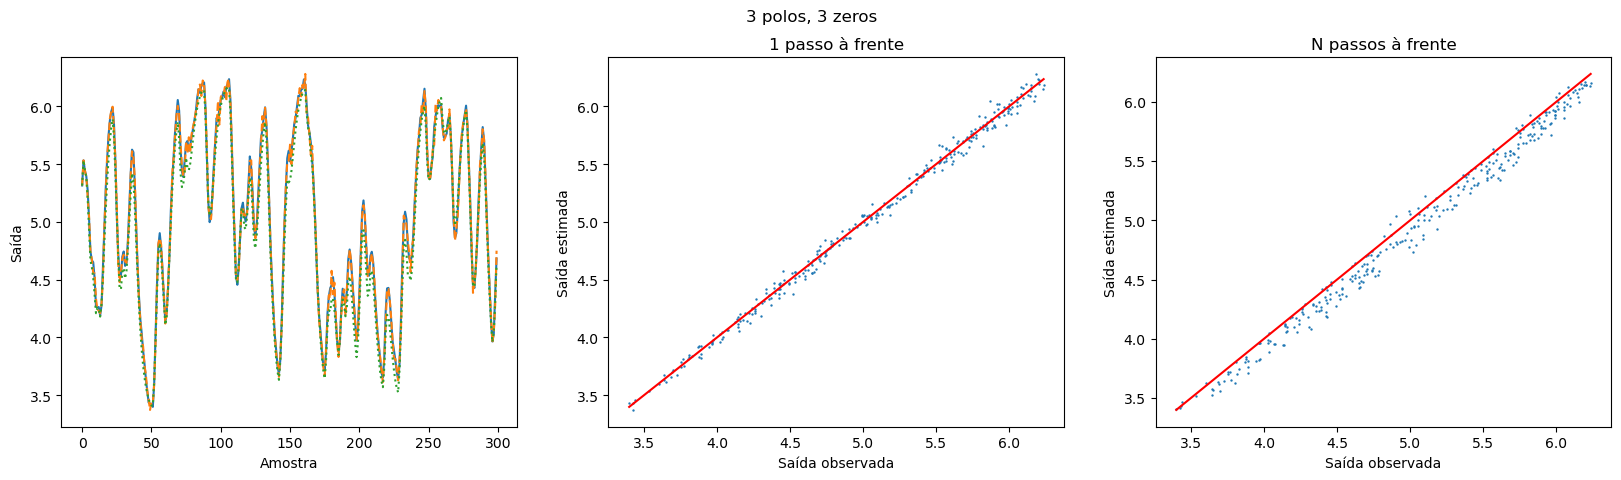

In [17]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=3, pole_count=3)

# Modelagem do segundo sistema

Como segundo sistema, foi utilizado os dados de trocador de calor.

Os dados consistem em uma entrada, representando a vazão do fluído, e uma saída, representando a temperatura de saída, e estão disponíveis no [link](https://ftp.esat.kuleuven.be/pub/SISTA/data/process_industry/exchanger.dat.gz).

In [18]:
url = 'https://ftp.esat.kuleuven.be/pub/SISTA/data/process_industry/exchanger.dat.gz'
data = pd.read_csv(url, sep='\t', usecols=[1, 2], names=['u', 'y'])
print(data)

u_est, y_est, u_val, y_val = prepare_data(data)

             u        y
0     0.300000  98.6281
1     0.300000  98.6281
2     0.300000  98.6281
3     0.300000  98.6281
4     0.300000  98.6281
...        ...      ...
3995  0.197134  97.5200
3996  0.627054  96.6251
3997  0.504197  96.1861
3998  0.240332  96.4817
3999  0.667348  95.5231

[4000 rows x 2 columns]


## Modelagem com 1 zero e 1 polo

Parâmetros estimados

a = [1.00048956]
b = [-0.13980119]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.280337  0.762944      0.009782              0.529378

Statistics=0.920, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 28.567
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.088, data does not look normal (reject H0)

N passos à frente
                 MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  90.000538  0.014603      8.373848              4.458611

Statistics=0.970, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 8.866
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.0

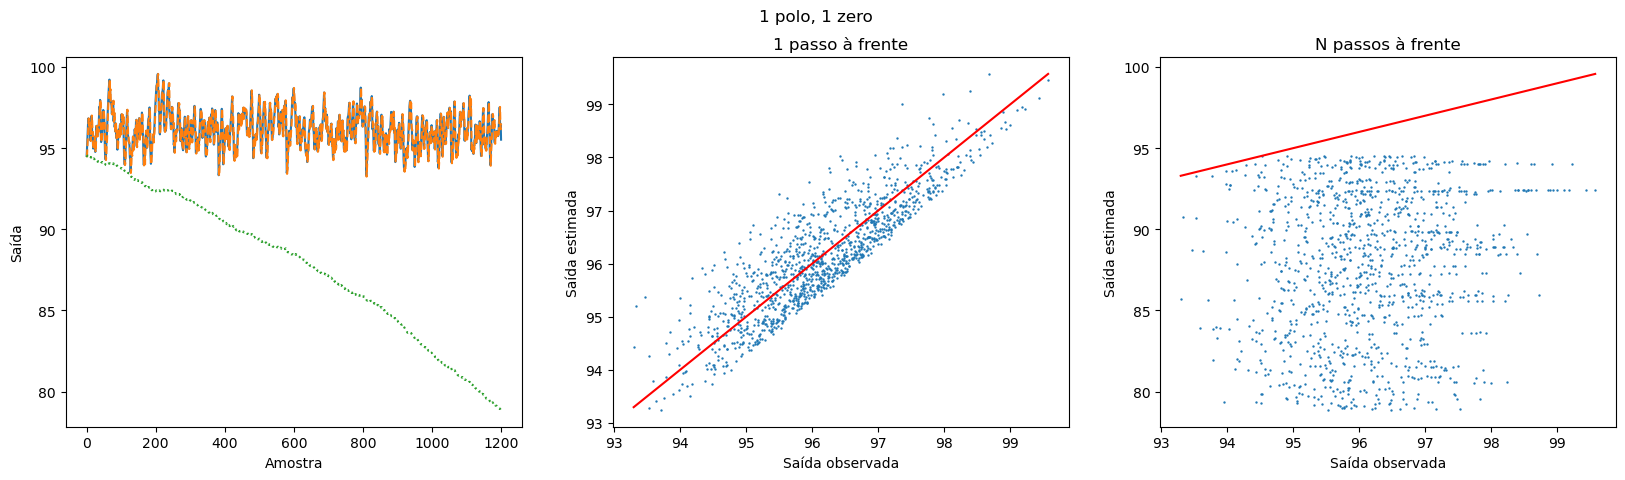

In [19]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=1, pole_count=1)

## Modelagem com 1 zero e 2 polos

Parâmetros estimados

a = [ 1.29132441 -0.29259526]
b = [0.34457805]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.266254  0.777284     -0.015801              0.515756

Statistics=0.919, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 31.017
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.088, data does not look normal (reject H0)

N passos à frente
                 MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  56.453065  0.015643     -6.452031              3.850242

Statistics=0.979, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 4.688
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (re

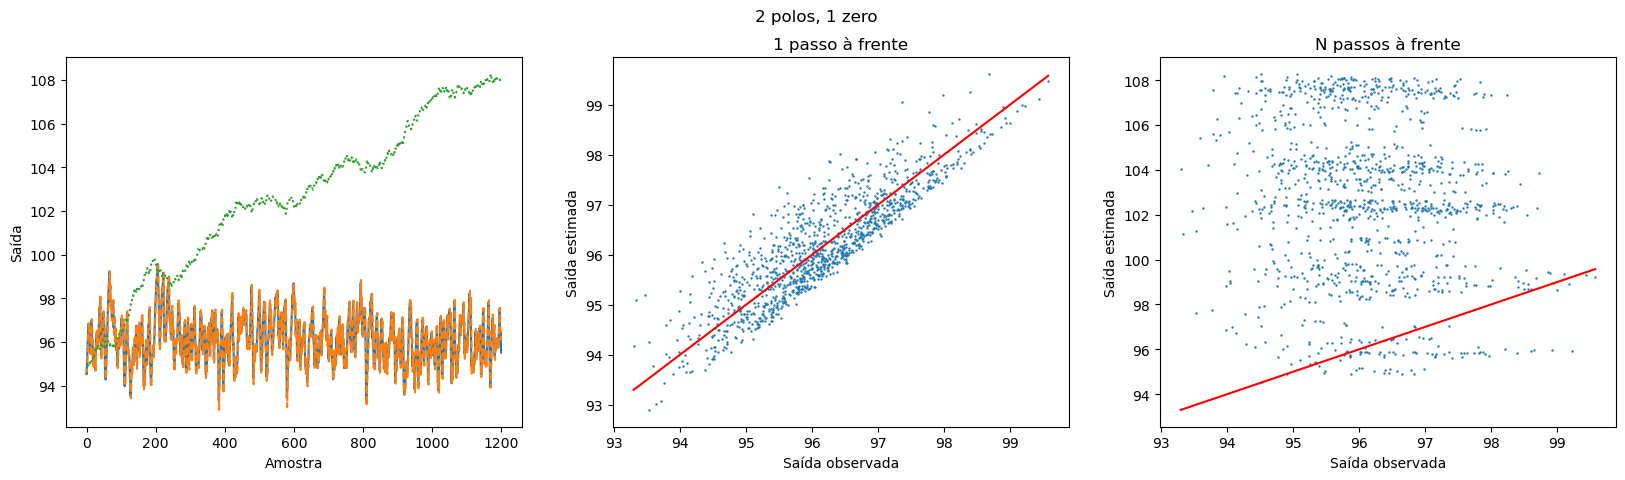

In [20]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=1, pole_count=2)

## Modelagem com 1 zero e 3 polos

Parâmetros estimados

a = [ 1.30217606 -0.33454033  0.03102851]
b = [0.36245678]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.265997  0.776198      -0.01711              0.515465

Statistics=0.918, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 31.505
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.088, data does not look normal (reject H0)

N passos à frente
                 MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  61.007461  0.016061     -6.856816              3.740527

Statistics=0.980, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 4.366
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not loo

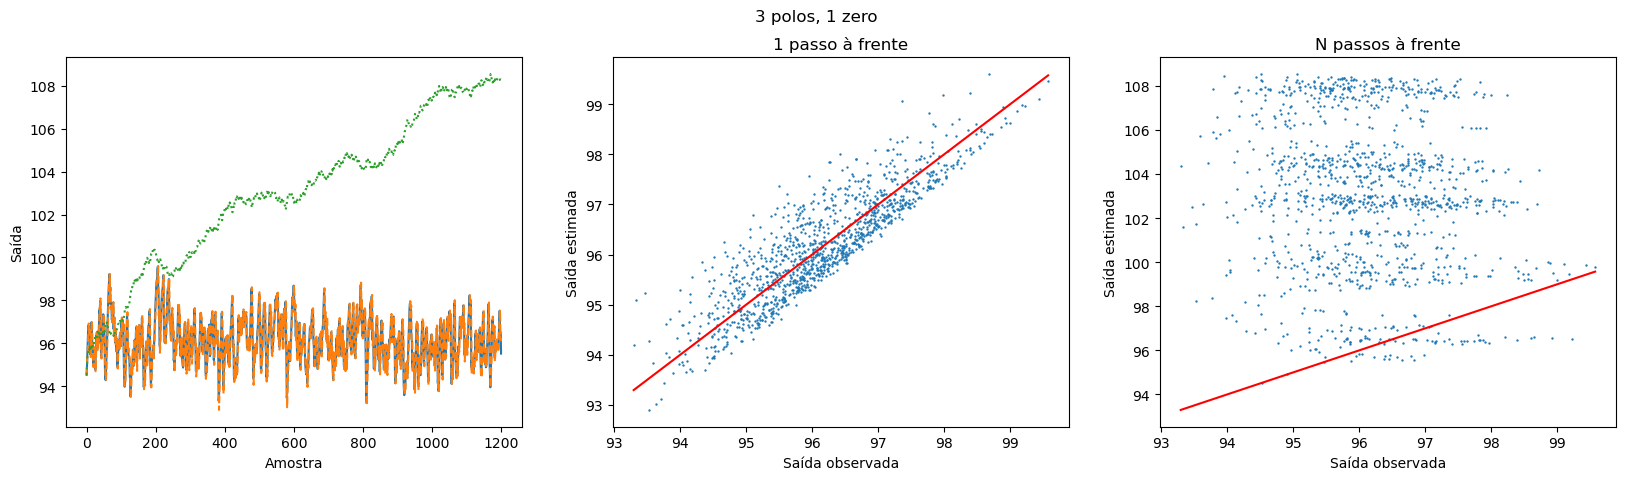

In [21]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=1, pole_count=3)

## Modelagem com 2 zeros e 1 polo

Parâmetros estimados

a = [1.0003482]
b = [-0.15602721  0.05513212]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.280326  0.762191      0.007422              0.529406

Statistics=0.920, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 28.368
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.088, data does not look normal (reject H0)

N passos à frente
                 MSE      R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  46.079441  0.01485       6.01533              3.145671

Statistics=0.980, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 5.191
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (rejec

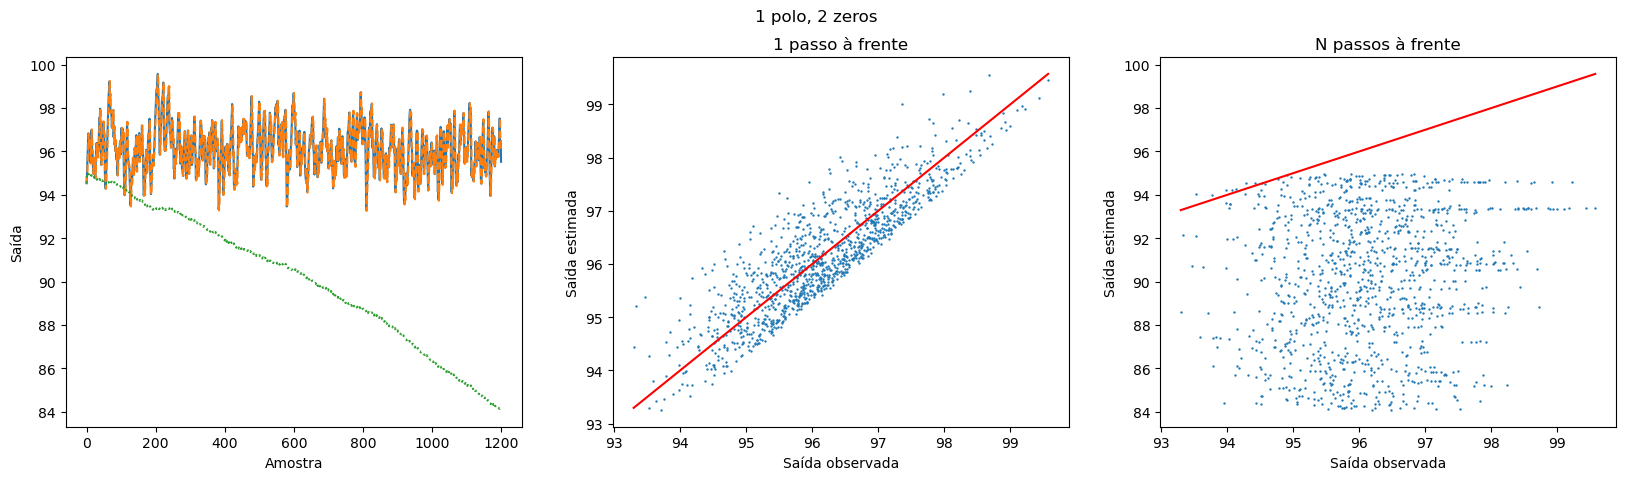

In [22]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=2, pole_count=1)

## Modelagem com 2 zeros e 2 polos

Parâmetros estimados

a = [ 1.29576855 -0.29693701]
b = [ 0.36651583 -0.05011766]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.266261  0.777925     -0.014349              0.515805

Statistics=0.919, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 30.710
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.088, data does not look normal (reject H0)

N passos à frente
                 MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  50.705335  0.015888      -6.06139              3.736962

Statistics=0.980, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 4.418
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not lo

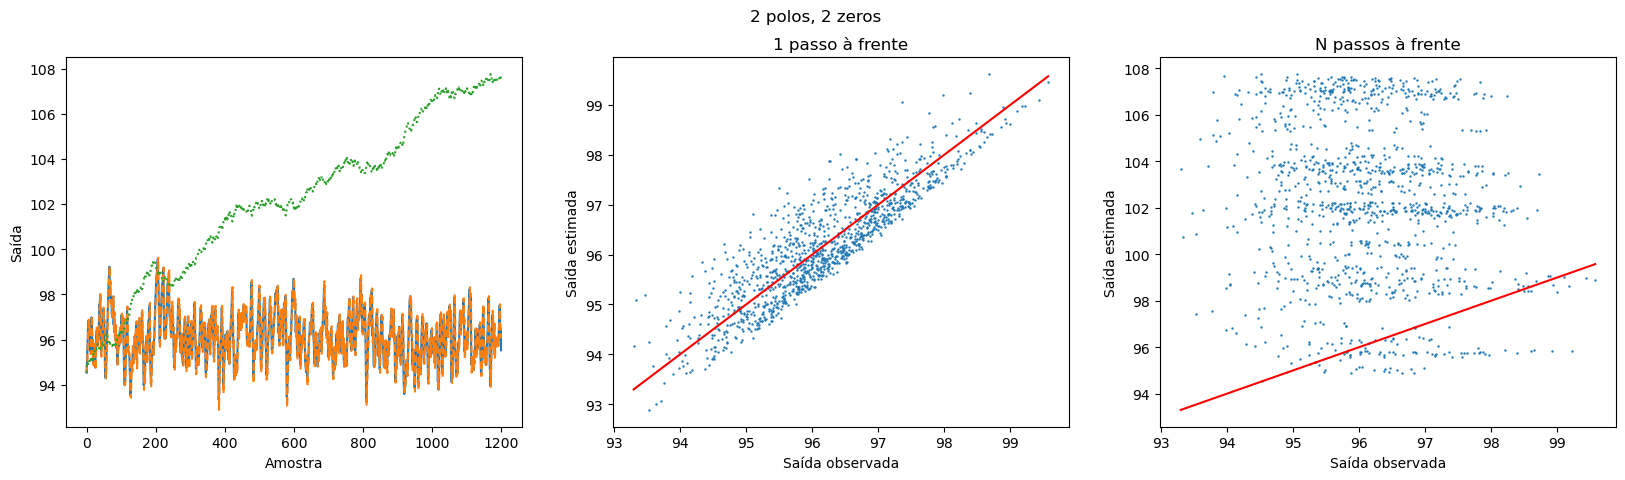

In [23]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=2, pole_count=2)

## Modelagem com 2 zeros e 3 polos

Parâmetros estimados

a = [ 1.3545301  -0.46695694  0.11148068]
b = [ 0.52835908 -0.27310603]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.265954  0.776525     -0.011588              0.515577

Statistics=0.919, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 31.355
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.088, data does not look normal (reject H0)

N passos à frente
                 MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  36.350948  0.018189     -5.124776              3.176102

Statistics=0.984, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 3.493
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data

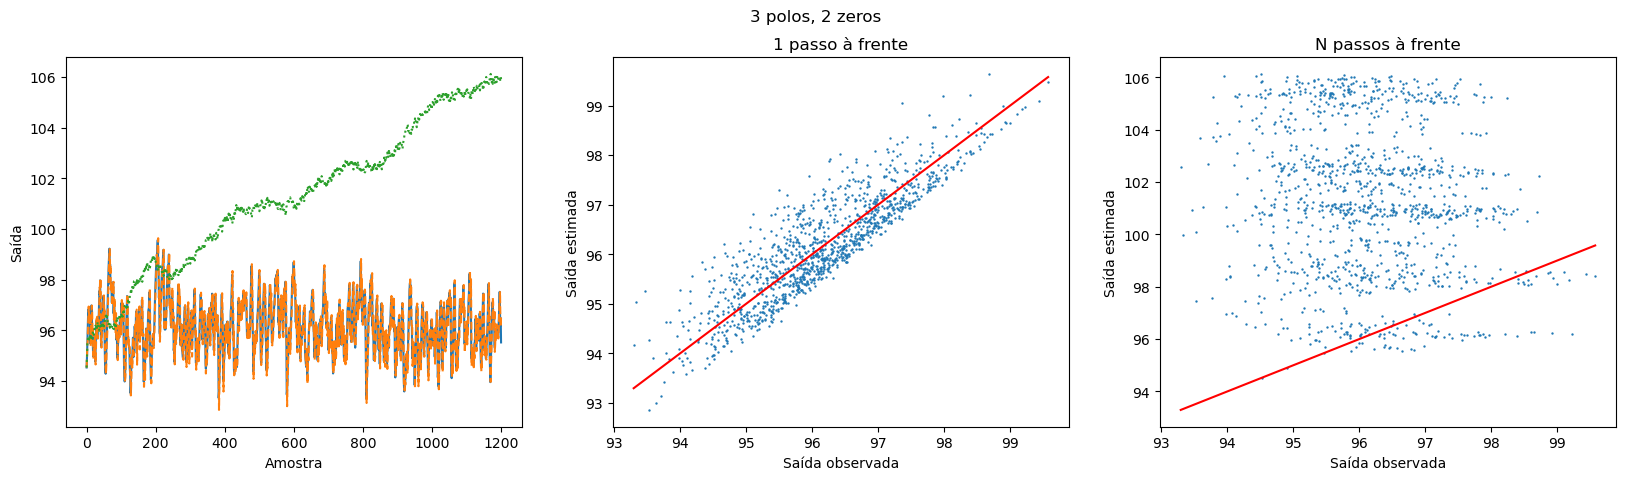

In [24]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=2, pole_count=3)

## Modelagem com 3 zeros e 1 polo

Parâmetros estimados

a = [1.00022608]
b = [-0.17048714  0.04111898  0.06210554]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.280094  0.761712      0.005262              0.529213

Statistics=0.921, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 28.120
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.088, data does not look normal (reject H0)

N passos à frente
                MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  21.29959  0.015885      4.043172              2.225388

Statistics=0.990, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 2.573
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look 

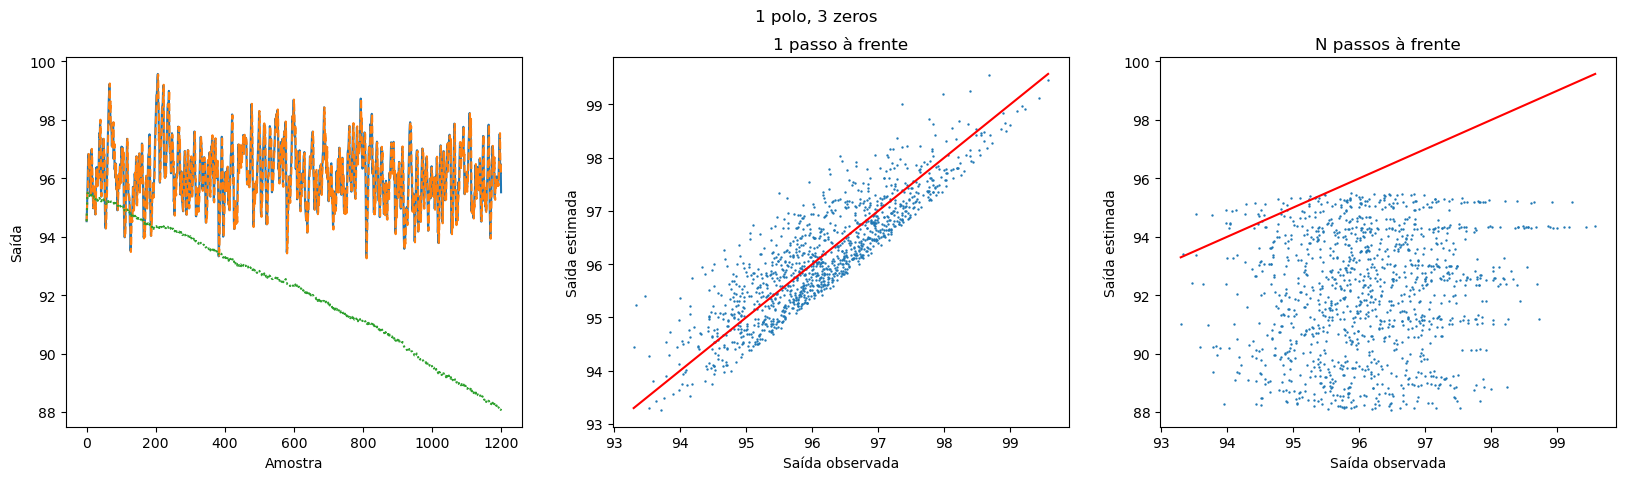

In [25]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=3, pole_count=1)

## Modelagem com 3 zeros e 2 polos

Parâmetros estimados

a = [ 1.30522882 -0.30628199]
b = [ 0.40226491 -0.03472247 -0.08291086]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.266063  0.778961     -0.013143              0.515646

Statistics=0.920, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 30.541
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.088, data does not look normal (reject H0)

N passos à frente
                 MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  47.025681  0.017219     -5.936369              3.432958

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 3.749
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data

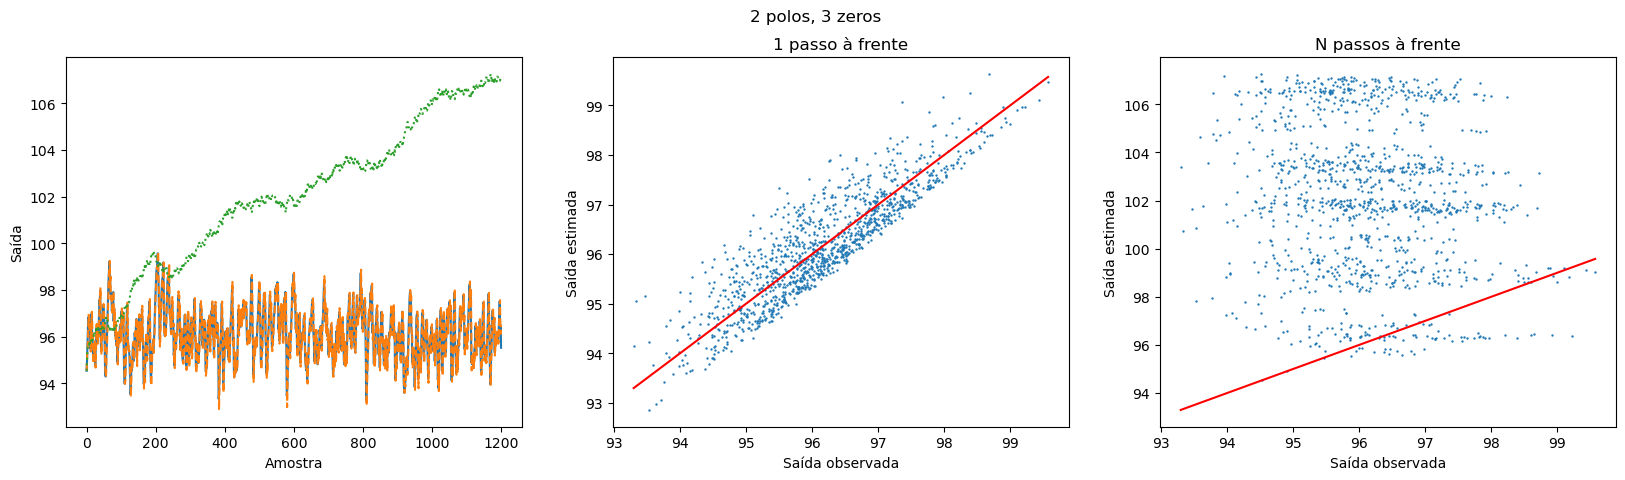

In [26]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=3, pole_count=2)

## Modelagem com 3 zeros e 3 polos

Parâmetros estimados

a = [ 1.36423919 -0.47680102  0.11173288]
b = [ 0.56491221 -0.2580267  -0.08392652]

1 passo à frente
            MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_hat  0.265958  0.777469     -0.009925              0.515616

Statistics=0.919, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 31.337
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.088, data does not look normal (reject H0)

N passos à frente
                 MSE       R^2  Média (Erro)  Desvio padrão (Erro)
y_n_steps  29.689757  0.019834     -4.569132              2.968634

Statistics=0.986, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 3.238
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500:

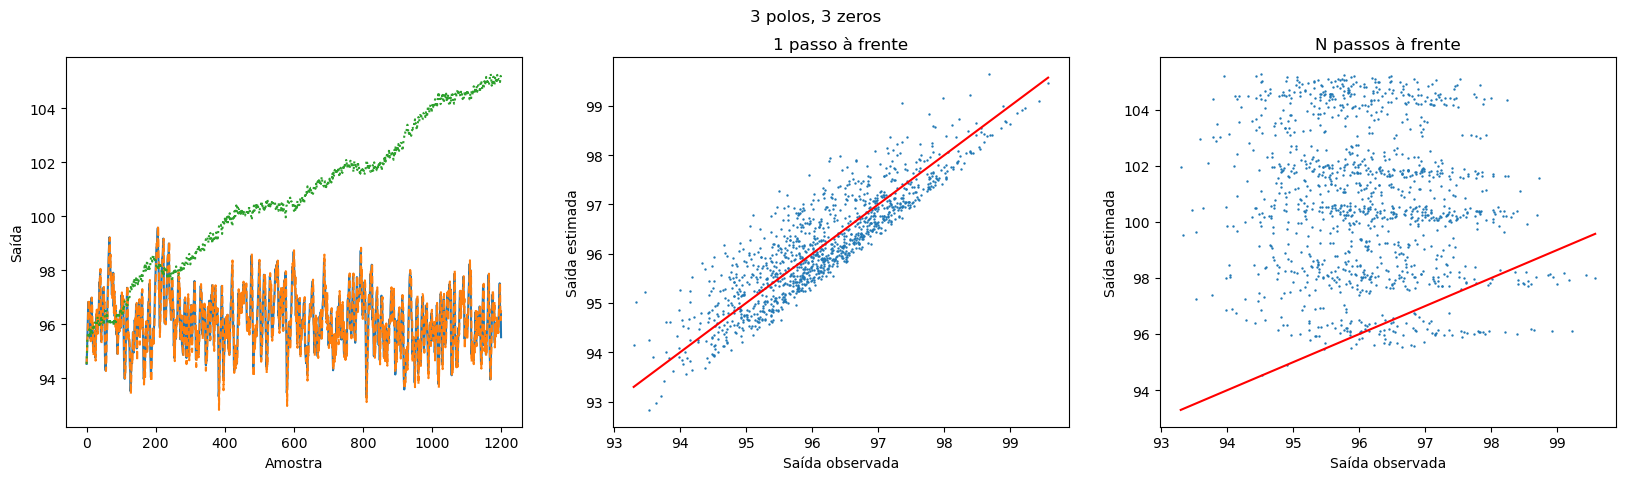

In [27]:
process_data(u_est=u_est, y_est=y_est, u_val=u_val, y_val=y_val, zero_count=3, pole_count=3)

# Perguntas

1. Quais valores de MSE obtidos? Fazer uma tabela com os valores de a, b, MSE (estimação e validação), etc para o modelo ARX.

    R: Para o primeiro modelo foram obtidos os seguintes resultados:

    |$\hat{a_1}$|$\hat{a_2}$|$\hat{a_3}$|$\hat{b_0}$|$\hat{b_1}$|$\hat{b_2}$|MSE - 1 passo à frente|MSE - N passos à frente|
    |-|-|-|-|-|-|-|-|
    |0,956330|||0,042706|||0,039575|0,281191|
    |1,751126|-0,784400||0,031656|||0,013269|0,107390|
    |2,106818|-1,553719|0,421169|0,024795|||0,009866|0,111632|
    |0,931914|||-0,002550|0,069269||0,032679|0,180191|
    |1,684596|-0,733779||0,004124|0,043231||0,010009|0,053919|
    |1,988847|-1,375844|0,346751|0,003195|0,035818||0,007628|0,043677|
    |0,886992|||-0,002882|0,002067|0,111373|0,015722|0,070425|
    |1,494615|-0,577797||0,002484|0,003918|0,074326|0,003124|0,016869|
    |1,648876|-0,887062|0,161424|0,002160|0,003079|0,069388|0,002723|0,013489|

    Para o segundo modelo for obtidos os seguintes resultados:

    |$\hat{a_1}$|$\hat{a_2}$|$\hat{a_3}$|$\hat{b_0}$|$\hat{b_1}$|$\hat{b_2}$|MSE - 1 passo à frente|MSE - N passos à frente|
    |-|-|-|-|-|-|-|-|
    |1,000489|||-0,139801|||0,280337|90,000538|
    |1,291324|-0,292595||0,344578|||0,266254|56,453065|
    |1,302176|-0,334540|0,031028|0,362456|||0,265997|61,007461|
    |1,000348|||-0,156027|0,055132||0,280326|46,079441|
    |1,295768|-0,296937||0,366515|-0,050117||0,266261|50,705335|
    |1,354530|-0,466956|0,111480|0,528359|-0,273106||0,265954|36,350948|
    |1,000226|||-0,170487|0,041118|0,062105|0,280094|21,299590|
    |1,305228|-0,306281||0,402264|-0,034722|-0,082910|0,266063|47,025681|
    |1,364239|-0,476801|0,111732|0,564912|-0,258026|-0,083926|0,265958|29,689757|

    Para este modelo não foi considerado o efeito do atraso de transporte. Por ser um sistema térmico, melhores resultados poderão ser obtidos considerando um atraso apropriado durante a modelagem.



2. Qual foi o melhor modelo matemático ARX em termos de MSE obtido para representar os sistemas dinâmicos avaliados (para previsão de 1 ou n passos à frente).

    R: Adotando o crtério de menor MSE, os melhores modelos são os de 3 polos e 3 zeros para o primeiro caso (secador de cabelo) e 3 polos e 2 zeros para o segundo caso (trocador de calor), ambos cosiderando somente 1 passo à frente.

3. Baseado em que escolheu qual é o melhor modelo (MSE de estimação ou validação) na questão 2 para o modelo ARX?

    R: Todos os valores de MSE apresentados nas tabelas acima referem-se ao conjunto de dados de validação.

4. Realizar uma análise quanto a normalidade dos resíduos (se é um ruído branco com média aproximadamente zero ou não) usando (pelo menos 2) testes de normalidade.

    R: Para o primeiro modelo, a tabela a seguir mostra se os testes de normalidade aceitam a hipótese do resíduo ser um ruído branco:

    |Zeros|Polos|Shapiro-Wilk (1 passo à frente)|Shapiro-Wilk (N passos à frente)|Anderson-Darling (1 passo à frente)|Anderson-Darling (N passos à frente)|
    |-|-|-|-|-|-|
    |1|1|Sim|Não|Sim|Não|
    |1|2|Sim|Sim|Sim|Sim|
    |1|3|Sim|Não|Sim|Não|
    |2|1|Sim|Não|Sim|Não|
    |2|2|Sim|Sim|Sim|Não|
    |2|3|Sim|Sim|Sim|Sim|
    |3|1|Sim|Não|Sim|Não|
    |3|2|Sim|Sim|Sim|Sim|
    |3|3|Sim|Sim|Sim|Sim|

    Para o segundo modelo, todos os testes rejeitaram a hipótese dos resíduos serem connsiderado como ruído branco. Este resultado pode ser explicado pelo fato do modelo não ser linear, sendo necessária a aplicação de outras técnicas de modelagem que sejam mais apropriadas.